# Homework 1: Optimization for the Traveling Salesman Problem

In this assignment, you will implement three optimization algorithms to solve a version of the Traveling Salesman Problem (TSP):

- Problem 1: **Hill-Climbing Search**
- Problem 2: **Simulated Annealing**
- Problem 3: **Genetic Algorithm**

This version of the TSP consists of a fully connected graph of cities, such that every city is reachable from every other city, though the layout of the cities (and thus, their distances between one another) is randomized. A **solution** to the TSP is a path that visits each city exactly once, and the goal is to find the solution with the shortest path length. A "path" in this case is a list of cities -- so, the path `['Albany', 'Boston', 'Charleston']` visits each of those cities in that order. The instructor-provided code sets up the problem, and computes the length of a path for you -- your code is just focused on generating possible solutions (i.e. permutations of the list of cities). 

However, your code is only allowed to test a **limited number of solutions** -- that is, you can't just try as many solutions as you like. This limit on the number of solutions you are allowed to test is provided to your code, however, so your code can use this to narrow in on a desired solution when you start approaching that limit. 

## Specifications

#### Required packages
- matplotlib

#### The "run_tsp" function

For all three problems, you are provided with the function `run_tsp`. This function sets up an instance of the traveling salesman problem, and then runs a function you provide it (`solve`) to try and find the best solution. The function signature of `run_tsp` is as follows: 

`run_tsp(solve, city_count, max_steps, seed) -> list(str), float, int`
- `solve` (function): This is the function you provide that solves the TSP problem. An example is provided further below.
- `city_count` (int): The number of cities created
- `max_steps` (int, optional): The maximum number of times your function is allowed to test a possible solution. If this value isn't provided (or is not a positive integer), then no limit is set.
- `seed` (int, optional): A random seed that is used to generate the problem. If no seed is provided, a new seed is randomly created.
- `plot` (boolean, optional): If `False`, it will not plot the final solution after the solver completes. By default, this value is `True`
- **Return value**: `final_path` (list of strings), `final_length` (float), `final_steps` (int)

#### Your "solve" function

Your task is to implement the `solve` function, and test it with the provided `run_tsp` function. The signature of the `solve` function is as follows:

`solve(cities, get_path_length, plot_path, max_steps) -> list(str)`
- `cities` (list of strings): A list of city names. Note that city coordinates, etc. are not provided.
- `get_path_length` (function `(list(str))->(int)`): Given a list of city names, this function returns the total distance of the path between them (in the order in which the city names are listed). This function can only be called a maximum of `max_steps` times. 
- `plot_path` (function `(list(str))->()`): Given a list of city names, this function visualizes the path connecting each of these cities. 
- `max_steps` (int or `Inf`): The maximum number of times `get_path_length` can be called. If there is no upper limit, `max_steps` is set to infinity.
- **Return value**: `final_path` (list of strings): The final, best path between cities decided upon by your program. Note that it should visit every city exactly once! 

The code shared by all three problems is provided below.

In [251]:
# Traveling Salesman Problem -- Setup code

import math
import random
import matplotlib.pyplot as plt

# List of city names
city_names = ['Albany','Boston','Charleston','Denver','El Paso','Fairfax','Grand Rapids','Houston','Indianapolis','Jersey City','Knoxville','Los Angeles','Marblehead','New York','Olympus','Philadelphia','Quincy','Raleigh','Salem','Troy','Utica','Voorheesville','Worcester','Xerxes','Yonkers','Zanesville']


# The run_tsp function. Use this to generate a TSP instance, 
# and run your code to try and find the best solution within
# the total number of steps (number of times a solution is 
# allowed to be tested).
def run_tsp(solve, city_count, max_steps = math.inf, seed = None, plot = True):

    if(seed): random.seed(seed)
    if (not max_steps) or not (max_steps > 0): max_steps = math.inf
    
    # Generate the cities
    city_coords = {}
    for i in range(city_count):
        city = city_names[i % len(city_names)]
        if(i >= len(city_names)): city = "".join(["New "]*math.floor(i / len(city_names))) + city
        
        city_coords[city] = (round(random.random(),3)*1000, round(random.random(),3)*1000);

    # Step counter variable initially at zero
    step_counter = 0
        
    # Define local functions
    
    def distance(p1, p2):
        return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

    def get_path_length(path):
        nonlocal step_counter
        step_counter += 1

        if (step_counter >= max_steps):
            raise ValueError("Error: maximum number of solutions tested")
        
        if set(path) != set(city_coords.keys()) or len(path) != len(city_coords):
            raise ValueError("Invalid path: must include each city exactly once.")
    
        total = 0.0
        for i in range(len(path)-1):
            a, b = path[i], path[(i + 1) % len(path)]
            total += distance(city_coords[a], city_coords[b])
    
        return total
    
    def plot_path(path):
        x = [city_coords[city][0] for city in path]
        y = [city_coords[city][1] for city in path]
        plt.figure(figsize=(6, 6))
        plt.plot(x, y, 'o-')
        for city in path:
            plt.text(city_coords[city][0], city_coords[city][1], city)
        plt.title(f"Path length: {get_path_length(path):.2f}")
        plt.show()

    # City names provided to solver
    cities = list(city_coords.keys())
    
    # Run the provided solver
    final_path = solve(cities, get_path_length, plot_path, max_steps)

    # Output final solution
    final_steps = step_counter
    step_counter = 0
    final_length = get_path_length(final_path)

    print(f"""Number of steps: {final_steps} / {max_steps}
Final path length: {final_length}
Final path: {final_path}
""")
    
    if(plot): plot_path(final_path)

    return final_path, final_length, final_steps

## Example solve functions

### Brute-force solver

This solver just runs through every possible permutation of paths, checking every one, until it has exhausted all possible options or runs out of allowed steps. If allowed to finish, it *will* find the best possible solution -- though of course, the runtime increases exponentially with the number of cities.

In [198]:
import itertools

def brute_force_solve(cities, get_path_length, plot_path, max_steps):
    best_path = None
    best_cost = float('inf')

    # Try all permutations of the city list
    for perm in itertools.permutations(cities):
        try:
            cost = get_path_length(list(perm))
            if cost < best_cost:
                best_path = list(perm)
                best_cost = cost
        except ValueError:
            break  # Stop if max_steps exceeded

    return best_path

#### Results

(Click the arrow to the left of this cell to hide/show the cells below)

Number of steps: 720 / 1000
Final path length: 1552.5174119699395
Final path: ['Charleston', 'Fairfax', 'Boston', 'El Paso', 'Albany', 'Denver']


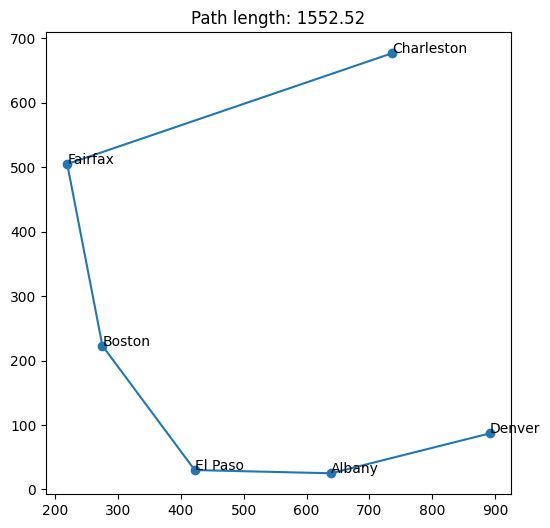

In [221]:
# Small sample problem: 6 cities
run_tsp(brute_force_solve, city_count=6, max_steps=1000, seed=42, plot=True);

In [203]:
# Medium sample problem: 10 cities
run_tsp(brute_force_solve, city_count=10, max_steps=10000000, seed=42, plot=False);

Number of steps: 3628800 / 10000000
Final path length: 2030.8981972383071
Final path: ['Charleston', 'Houston', 'Indianapolis', 'Fairfax', 'Grand Rapids', 'Boston', 'El Paso', 'Albany', 'Jersey City', 'Denver']


In [204]:
# Large sample problem: 20 cities
# (cannot be solved within the provided step limit)
run_tsp(brute_force_solve, city_count=20, max_steps=10000000, seed=42, plot=False);

KeyboardInterrupt: 

### Random permutation solver

This solver starts from a random path, and then repeatedly swaps two random cities. It keeps track of the best path and returns that at the end.

In [167]:
# Helper function to swap random cities
# Feel free to use in your own code

import datetime

def mutate(path, seed = None):
    """Swaps two random cities to generate a neighbor."""

    if seed is None: random.seed()
    else: random.seed(seed)
    
    a, b = random.sample(range(len(path)), 2)
    path[a], path[b] = path[b], path[a]
    return path

In [168]:
def random_solve(cities, get_path_length, plot_path, max_steps):

    # Start with a random tour
    current = cities[:]
    random.shuffle(current)

    best_path = current
    best_cost = get_path_length(current)

    # Repeatedly attempt random permutations of the current path
    while True:
        current = mutate(current[:])
        try:
            current_cost = get_path_length(current)
        except ValueError:
            break  # Max steps reached

        if current_cost < best_cost:
            best_path = current
            best_cost = current_cost

    return best_path

#### Results

Number of steps: 10000 / 10000
Final path length: 2596.916635495615
Final path: ['Charleston', 'Denver', 'Jersey City', 'Albany', 'El Paso', 'Grand Rapids', 'Boston', 'Fairfax', 'Indianapolis', 'Houston']


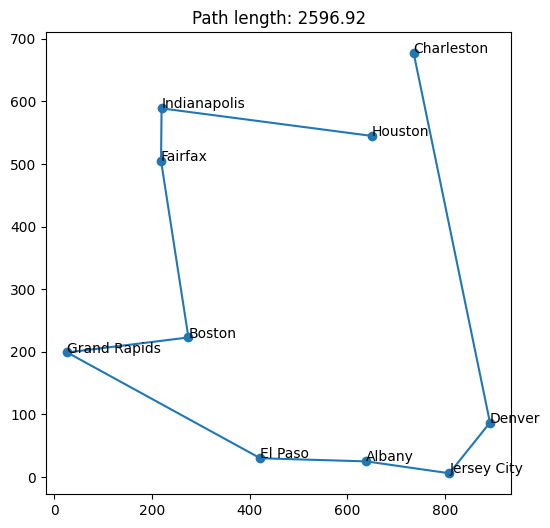

In [175]:
run_tsp(random_solve, city_count=10, max_steps=10000, seed=42);


## Problem 1: Local hill climbing

### 1.1: Implementation 

In this problem, you need to write `hill_climbing_solve`: a solver that implements the local hill climbing search optimization algorithm. You may find it helpful to use the `mutate` function from the random permutation solver above.

#### Local Hill Climbing Algorithm
Hill climbing is a greedy local search algorithm that starts with a candidate solution and makes small changes to it, always moving to a neighbor if it improves the solution. In this context:

- A candidate solution is a specific ordering (permutation) of the cities.
- A neighbor is another tour created by slightly modifying the current one, such as by swapping two cities (mutation)
- The "hill" is the quality of the solution, measured by the total tour length (shorter = better).
- The algorithm continues climbing until it reaches a point where no local neighbor is better (a local minimum).

#### Your task

1. Start from a random path through the cities.
2. Generate a "neighbor solution" of that path, i.e., swapping two cities with the `mutate` function above.
3. Evaluate the neighbor using the provided `get_path_length` function -- if the neighbor is better, move to it.
4. Repeat until no better neighbor can be found, or until you run out of steps.

In [184]:
def hill_climbing_solve(cities, get_path_length, plot_path, max_steps):
    # Replace the code below with your implementation
    best_path = cities
    return best_path

In [185]:
## INSTRUCTOR SOLUTION BELOW (NOT PROVIDED TO STUDENTS)

def hill_climbing_solve(cities, get_path_length, plot_path, max_steps):

    def mutate(path):
        """Swaps two random cities to generate a neighbor."""
        a, b = random.sample(range(len(path)), 2)
        path[a], path[b] = path[b], path[a]
        return path

    # Start with a random tour
    current = cities[:]
    random.shuffle(current)
    current_cost = get_path_length(current)

    while True:
        neighbor = mutate(current[:])
        try:
            neighbor_cost = get_path_length(neighbor)
        except ValueError:
            break  # Max steps reached

        if neighbor_cost < current_cost:
            current = neighbor
            current_cost = neighbor_cost
        else:
            # No improvement; we can decide whether to keep trying
            continue  # Optional: Add a max plateau threshold

    return current

In [252]:
# 1.1.1: (1pt) Your implementation will be tested on Submitty with 4 cities and 50 steps; it should find the most optimal solution
print("Most optimal solution:")
run_tsp(brute_force_solve, city_count=4, max_steps=100, seed=42, plot=False);
print("Hill-climbing solve:")
run_tsp(hill_climbing_solve, city_count=4, max_steps=50, seed=42, plot=False);

# 1.1.2: (1pt) Your implementation will be tested on Submitty with 6 cities and 50 steps; it should find a solution with path length < 2000 with seed 42.
run_tsp(hill_climbing_solve, city_count=6, max_steps=50, seed=42, plot=False);

# 1.1.3: (1pt) Your implementation will be tested on Submitty with 12 cities and 50 steps; it should find a solution with path length < 2500 with seed 42.
run_tsp(hill_climbing_solve, city_count=10, max_steps=50, seed=42, plot=False);


Most optimal solution:
Number of steps: 24 / 100
Final path length: 1285.1284188748093
Final path: ['Boston', 'Albany', 'Denver', 'Charleston']

Hill-climbing solve:
Number of steps: 50 / 50
Final path length: 1285.1284188748093
Final path: ['Boston', 'Albany', 'Denver', 'Charleston']

Number of steps: 50 / 50
Final path length: 1920.1860820946576
Final path: ['Boston', 'Fairfax', 'Charleston', 'Denver', 'Albany', 'El Paso']

Number of steps: 50 / 50
Final path length: 2397.500173066743
Final path: ['El Paso', 'Albany', 'Jersey City', 'Denver', 'Houston', 'Charleston', 'Indianapolis', 'Fairfax', 'Grand Rapids', 'Boston']



### 1.2: Results and analysis

Try running your solver with a few different city counts: you can try 6, 12, and 20, just as with the example solutions above. Try experimenting with different seeds as well.

Based on your results, answer the following two questions in a couple of brief sentences each: 

1.2.1. **(2 pts)** What kind of results are you getting for different city counts? How do your results compare to the paths found by the example solvers above -- with what city counts is your solver able to find an optimal or near-optimal solution, and at what point are there too many cities for it to find a good solution?

*<1.2.1 answer here>*

1.2. **(2 pts)** What do you think is causing this algorithm to run into trouble -- and what kinds of modifications could you make to it to improve it?

*<1.2.2 answer here>*

## Problem 2: Simulated annealing

In [99]:
## INSTRUCTOR SOLUTION BELOW (NOT PROVIDED TO STUDENTS)

def simulated_annealing_solver(cities, get_path_length, plot_path, max_steps):
    import math
    import copy

    def mutate(path):
        """Swaps two cities to create a neighbor."""
        a, b = random.sample(range(len(path)), 2)
        path[a], path[b] = path[b], path[a]
        return path

    # Initial solution
    current = cities[:]
    random.shuffle(current)
    current_cost = get_path_length(current)
    best = current[:]
    best_cost = current_cost

    # Temperature parameters
    T0 = 1000
    alpha = 0.995
    T = T0

    steps = 0
    while True:
        neighbor = mutate(current[:])
        try:
            neighbor_cost = get_path_length(neighbor)
        except ValueError:
            break  # Max steps reached

        delta = neighbor_cost - current_cost

        # Accept new path if it's better, or with some probability if worse
        if delta < 0 or random.random() < math.exp(-delta / T):
            current = neighbor
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best = current[:]
                best_cost = current_cost

        T *= alpha  # Cool down

        steps += 1
        if T < 1e-3:
            break

    return best


In [255]:
run_tsp(simulated_annealing_solver, city_count=12, max_steps=3000, seed=42, plot=False);


Number of steps: 2758 / 3000
Final path length: 2360.7134607509965
Final path: ['Grand Rapids', 'Boston', 'Los Angeles', 'El Paso', 'Albany', 'Jersey City', 'Denver', 'Knoxville', 'Charleston', 'Houston', 'Indianapolis', 'Fairfax']



## Problem 3: Genetic algorithm

In [253]:
## INSTRUCTOR SOLUTION BELOW (not provided to students)

def genetic_algorithm_solver(cities, get_path_length, plot_path, max_steps):
    import random

    def mutate(path):
        a, b = random.sample(range(len(path)), 2)
        path[a], path[b] = path[b], path[a]
        return path

    def crossover(parent1, parent2):
        size = len(parent1)
        a, b = sorted(random.sample(range(size), 2))
        hole = [city for city in parent2 if city not in parent1[a:b]]
        return hole[:a] + parent1[a:b] + hole[a:]

    def tournament_selection(pop, fitnesses, k=3):
        contenders = random.sample(list(zip(pop, fitnesses)), k)
        return min(contenders, key=lambda x: x[1])[0]

    population_size = 50
    mutation_rate = 0.5
    generations = max_steps // population_size

    population = []
    fitnesses = []
    best = None
    best_cost = float('inf')

    # === Initialization ===
    for _ in range(population_size):
        individual = cities[:]
        random.shuffle(individual)
        try:
            fitness = get_path_length(individual)
        except ValueError:
            return best  # Stop immediately if step limit hit
        population.append(individual)
        fitnesses.append(fitness)
        if fitness < best_cost:
            best = individual
            best_cost = fitness

    # === Evolution Loop ===
    for _ in range(generations):
        new_population = []
        new_fitnesses = []
        for _ in range(population_size):
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:
                child = mutate(child)
            try:
                fitness = get_path_length(child)
            except ValueError:
                return best
            new_population.append(child)
            new_fitnesses.append(fitness)
            if fitness < best_cost:
                best = child
                best_cost = fitness

        population = new_population
        fitnesses = new_fitnesses

    return best
